In [1]:
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

### Generating Random Matricies with Desired Conditions


In [2]:
#Function that generates mxm A matrix with corresponding tau value and its 10 x0s
def generate(size,tau):
    c = np.random.uniform(-1,1,(size,size))
    c = np.triu(c,1)
    c = c + c.T
    c[abs(c) > tau] = 0
    c = c + np.diag(np.ones(size))
    
    x = np.random.normal(0,1,(size,10))
    return c,x

In [3]:
A1,x_1 = generate(100,0.01)
A2,x_2 = generate(100,0.1)
A3,x_3 = generate(500,0.01)
A4,x_4 = generate(500,0.1)
A5,x_5 = generate(2500,0.01)
A6,x_6 = generate(2500,0.1)


In [4]:
#calculating b0s given Ai and xi
def find_b30(A,x):
    w1 = 0.0001 * np.random.normal(0,1,(x.shape[0],1))
    w2 = 0.01 * np.random.normal(0,1,(x.shape[0],1))
    w3 = np.random.normal(0,1,(x.shape[0],1))
    w = np.array([w1,w2,w3])
    b_30 = []
    for i in w:
        for col in x.T:
            b0 = (A @ col).reshape(x.shape[0],1) 
            b = b0 + i
            b_30.append(b)
    return np.array(b_30)

In [5]:
#here first 10 colmns corresponds to first noise level and so on
b_30_1 = find_b30(A1,x_1)
b_30_2 = find_b30(A2,x_2)
b_30_3 = find_b30(A3,x_3)
b_30_4 = find_b30(A4,x_4)
b_30_5 = find_b30(A5,x_5)
b_30_6 = find_b30(A6,x_6)

In [6]:
def pseudo(A):
    U,S,V_T = np.linalg.svd(A, full_matrices = False)
    S_pinv = np.diag(1/S)
    S_pinv[S_pinv == inf] = 0
    A_pinv = np.matmul(V_T.transpose(),np.matmul(S_pinv,U.transpose()))
    return A_pinv

In [7]:
def find_err_pseudo(A,x,b):
    err_n1 = []
    err_n2 = []
    err_n3 = []
    A_pinv = pseudo(A) #we can use np.linalg.pinv also
    for i in range(30):
        x_hat = A_pinv @ b[i]
        x_0 = x[:,np.mod(i,10)].reshape(-1,1)
        if i <10:
            err1 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n1.append(err1)
        elif i >= 10 and i < 20:
            err2 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n2.append(err2)
        else:
            err3 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n3.append(err3)
    
    err_n1 = (np.sum(err_n1) / 10) ** 0.5
    err_n2 = (np.sum(err_n2) / 10) ** 0.5
    err_n3 = (np.sum(err_n3) / 10) ** 0.5
    err_full = [err_n1,err_n2,err_n3]
    return err_full

### Finding $E_{S,i}$ errors for Pseudo Inverse Algortihm

In [8]:
##Pseudo inverse method

err1 = find_err_pseudo(A1,x_1,b_30_1)
err2 = find_err_pseudo(A2,x_2,b_30_2)
err3 = find_err_pseudo(A3,x_3,b_30_3)
err4 = find_err_pseudo(A4,x_4,b_30_4)
err5 = find_err_pseudo(A5,x_5,b_30_5)
err6 = find_err_pseudo(A6,x_6,b_30_6)


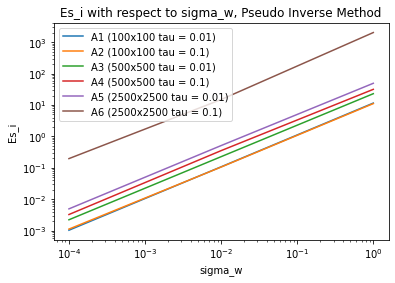

In [9]:
w = [0.0001,0.01,1]
plt.figure()
plt.plot(w,err1, label = "A1 (100x100 tau = 0.01)")
plt.plot(w,err2, label = "A2 (100x100 tau = 0.1)")
plt.plot(w,err3, label = "A3 (500x500 tau = 0.01)")
plt.plot(w,err4, label = "A4 (500x500 tau = 0.1)")
plt.plot(w,err5, label = "A5 (2500x2500 tau = 0.01)")
plt.plot(w,err6, label = "A6 (2500x2500 tau = 0.1)")
plt.title("Es_i with respect to sigma_w, Pseudo Inverse Method")
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')
plt.legend()
plt.show(block =False)

## CG Solver and Errors

In [10]:
def CGSolver(A,b,max_iter,tol):

    r = b.copy()
    d = r.copy()
    x = np.zeros((b.shape))
    
    condition = 13
    Q = np.zeros((b.shape[0],b.shape[0] + 1))
    orth_check = []
    
    for k in range(max_iter):
        A_d = A @ d
        
        Q[:,k] = r / np.linalg.norm(r)
        prev = r.T @ r # will be used in improvement
        alpha = (prev) / ( d.T @ A_d)
        x = x + alpha*d #approximate solution
        r = r - alpha*(A_d) #new residual

        if( k < condition ):
            norm = np.linalg.norm( Q[:,:k+1].T @ Q[:,:k+1] - np.eye(k+1,k+1) )
            orth_check.append(norm)
        
        if np.linalg.norm(r) < tol:
            
            print("The number of iterations are", k + 1)
            break
        
        else:
            beta = (r.T @ r ) /prev #improvement
            d = r + beta*d #next search direction
    print(f'Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to {condition}:{orth_check[:condition]}')
    x = x.reshape(-1,1)
    return x

In [11]:
x_hat = CGSolver(A1 ,b = b_30_1[1].reshape(-1), tol=1e-15, max_iter = A1.shape[0])

The number of iterations are 8
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 8.980739833759846e-15, 1.6381586036938437e-14, 3.804051409263554e-14, 5.359350310411898e-14, 5.809676820637461e-14, 7.253277922804019e-14, 9.968748189440958e-14]


In [12]:
def getCGError(A,b,x):

    x_init = np.zeros((A.shape[0])).reshape(-1,1)
    err_n1 = []
    err_n2 = []
    err_n3 = []
    for i in range(30):
        x_hat = CGSolver(A = A ,b = b[i].reshape(-1), tol=1e-15, max_iter = A.shape[0])
        x_0 = x[:,np.mod(i,10)].reshape(-1,1)
        if i <10:
            err1 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n1.append(err1)
        elif i >= 10 and i < 20:
            err2 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n2.append(err2)
        else:
            err3 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n3.append(err3)
    
    err_n1 = (np.sum(err_n1) / 10) ** 0.5
    err_n2 = (np.sum(err_n2) / 10) ** 0.5
    err_n3 = (np.sum(err_n3) / 10) ** 0.5
    err_full = [err_n1,err_n2,err_n3]

    return err_full

### Finding $E_{S,i}$ errors for CG algortihm

In [13]:
err_es_a1 = getCGError(A1,b_30_1,x_1)
err_es_a2 = getCGError(A2,b_30_2,x_2)
err_es_a3 = getCGError(A3,b_30_3,x_3)
err_es_a4 = getCGError(A4,b_30_4,x_4)
err_es_a5 = getCGError(A5,b_30_5,x_5)
err_es_a6 = getCGError(A6,b_30_6,x_6)

The number of iterations are 8
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 8.452467014399015e-15, 3.199505776099816e-14, 6.35728346198287e-14, 9.480896497633134e-14, 1.1560206938210716e-13, 1.3222812638775962e-13, 1.7019072847837414e-13]
The number of iterations are 8
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 8.980739833759846e-15, 1.6381586036938437e-14, 3.804051409263554e-14, 5.359350310411898e-14, 5.809676820637461e-14, 7.253277922804019e-14, 9.968748189440958e-14]
The number of iterations are 8
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 1.2898206800235857e-14, 1.579650652253398e-14, 4.519849969497136e-14, 6.530591445384953e-14, 7.831386422996894e-14, 1.0270934743488206e-13, 1.398376691673318e-13]
The number of iterations are 8
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 1.5924313487746125e-15, 4.029014902811357e-15, 1.111893309781662e-14

The number of iterations are 9
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[4.440892098500626e-16, 7.035976830476667e-15, 1.75501081580769e-14, 2.947548337136674e-14, 3.3732307514736764e-14, 3.807183846762245e-14, 3.9195680848818866e-14, 4.540809371675979e-14, 5.162656657434081e-14]
The number of iterations are 9
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[1.1102230246251565e-16, 1.2430442165153987e-15, 3.42018655288833e-15, 7.953393126342711e-15, 2.180925421533093e-14, 5.213212035163467e-14, 8.550194018187305e-14, 1.1679514641472704e-13, 1.4457096895487476e-13]
The number of iterations are 9
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[4.440892098500626e-16, 1.840287022595279e-14, 2.4997724269274228e-14, 3.294613752407023e-14, 3.683193171794234e-14, 3.717182910789118e-14, 4.5805379431377e-14, 6.407200022287515e-14, 8.333696964944101e-14]
The number of iterations are 9
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 2

The number of iterations are 55
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[0.0, 1.2914920163657867e-15, 1.770398982793278e-15, 2.1153432451417173e-15, 2.3943712048442852e-15, 2.59249715197016e-15, 2.788577160338966e-15, 3.192045719925749e-15, 3.4699631865342223e-15, 3.736063808205994e-15, 3.960229895242038e-15, 4.148945976982191e-15, 4.3655583697237395e-15]
The number of iterations are 55
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[1.1102230246251565e-16, 2.2238316000367136e-16, 7.186153504706508e-16, 9.901039666908462e-16, 1.2870274600879907e-15, 1.490557045875454e-15, 1.7142188854887716e-15, 2.043965126710001e-15, 2.267050056988421e-15, 2.4861482357052865e-15, 2.7314659234448204e-15, 3.0445426514715525e-15, 3.329268492762011e-15]
The number of iterations are 55
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[0.0, 3.532708032038494e-16, 6.24502860685164e-16, 1.1718029794570644e-15, 1.8774519166870163e-15, 2.5548447171248235e-15, 3.4200666027694195e-

The number of iterations are 11
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[0.0, 1.0968283894573842e-15, 3.057106672623911e-15, 9.107581944673447e-15, 1.6892588056214095e-14, 2.8002543029325554e-14, 4.422928697437458e-14, 6.384191120921563e-14, 8.094025136303857e-14, 9.730192837145493e-14, 1.1283799911362859e-13]
The number of iterations are 11
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 2.0516284873171906e-15, 5.593154365210075e-15, 6.323795232929513e-15, 7.086494580138402e-15, 9.940240847755294e-15, 1.474105992702144e-14, 2.3814470984082274e-14, 4.200166679234471e-14, 6.200406136990257e-14, 8.911612020434909e-14]
The number of iterations are 11
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[1.1102230246251565e-16, 9.44520745235275e-16, 5.272315520270791e-15, 9.618915119289688e-15, 1.2619360062453578e-14, 1.4627016946953068e-14, 1.6405468781525e-14, 1.776941597400847e-14, 1.970501124132083e-14, 2.5035720238834026e-14, 3.006873

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[4.440892098500626e-16, 2.2278051585165665e-16, 2.50273652646508e-16, 3.802607474901219e-16, 5.968923398060466e-16, 7.826702206635352e-16, 8.819941666930916e-16, 4.331402097494752e-15, 7.52308043477786e-15, 1.0669494658718787e-14, 4.915117989092584e-14, 8.653302183384599e-14, 1.2209229229294273e-13]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[4.440892098500626e-16, 1.5492877422289535e-15, 2.1448642735375185e-15, 3.0558593355779704e-15, 3.743517854046356e-15, 4.39092887365797e-15, 5.167026096379777e-15, 8.404353294215311e-15, 1.2131638436377435e-14, 1.5377513413792526e-14, 1.8418273097143743e-14, 2.1531924040927853e-14, 2.4820127610646625e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 3.5729569842264323e-16, 5.609335702255235e-16, 7.882116634948454e-16, 1.2627140845856224e-15, 1.7632285446314281e-15, 2.2807942337433424e-15, 5.369769053999696e-15, 8.459652130565181e-15, 1.1082267793

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[0.0, 3.7209768014112356e-16, 6.339680275133288e-16, 9.333287389841597e-16, 1.3437985775399607e-15, 1.823855294571419e-15, 2.1760239867475157e-15, 2.7242408238471217e-15, 3.3348010810723454e-15, 4.128076590180883e-15, 4.556849921278675e-15, 4.920689708766743e-15, 5.202153499004177e-15]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 1.2381344339718246e-16, 6.219049486238842e-16, 1.6414057384805921e-15, 2.327595198596134e-15, 3.294455304333343e-15, 4.006690023571752e-15, 4.783436339075689e-15, 5.656336639120981e-15, 6.4767200033949844e-15, 7.666091374011445e-15, 8.988507066875802e-15, 1.073766498242064e-14]
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to 13:[2.220446049250313e-16, 5.561541624169294e-16, 6.050352896616027e-16, 8.811442961397438e-16, 1.265430050265216e-15, 1.5060673506547748e-15, 1.7055314562805818e-15, 2.10742108623618e-15, 2.6166785215407266e-15, 3.020704366082041e-15, 4.9567173

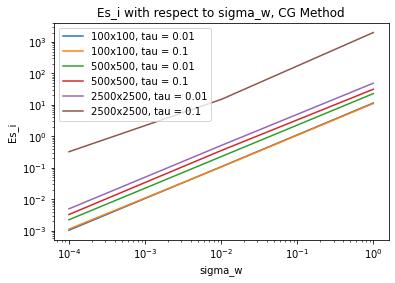

In [14]:
plt.figure()

plt.plot(w,err_es_a1, label = '100x100, tau = 0.01')
plt.plot(w,err_es_a2, label = '100x100, tau = 0.1')
plt.plot(w,err_es_a3,label = '500x500, tau = 0.01')
plt.plot(w,err_es_a4, label = '500x500, tau = 0.1')
plt.plot(w,err_es_a5, label = '2500x2500, tau = 0.01')
plt.plot(w,err_es_a6, label = '2500x2500, tau = 0.1')

plt.title("Es_i with respect to sigma_w, CG Method")
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')
plt.legend()
plt.show(block=False)

### Finding $E_{O,i}$ errors for CG algortihm

In [15]:
def CGSolverS(A,x_init,b,max_iter):

    r = b.copy()
    d = r.copy()
    x = x_init.copy()
    residual = np.zeros((max_iter))
    
    for k in range(max_iter):
        A_d = A @ d
        prev = r.T @ r
        alpha = prev/(d.T @ A_d)
        x = x + alpha*d
        r = r - alpha*A_d
        beta = (r.T @ r)/prev
        d = r + beta*d
        residual[k] = np.linalg.norm(b - np.matmul(A,x))
    return residual

In [16]:
def getCGErrorO(A,b,x,maxiter):
    x_init = np.zeros((A.shape[0])).reshape(-1,1)
    err_n1 = []
    err_n2 = []
    err_n3 = []
    err_sum = 0
    for i in range(30):
        res = CGSolverS(A = A, x_init = x_init ,b = b[i], max_iter = maxiter)
        err_sum = err_sum + res**2
        if i == 9:
            err_n1.append(err_sum)
        elif i == 19:
            err_n2.append(err_sum)
        elif i == 29:
            err_n3.append(err_sum)
    
    err_n1 = (np.array(err_n1) / 10) ** 0.5
    err_n2 = (np.array(err_n2) / 10) ** 0.5
    err_n3 = (np.array(err_n3) / 10) ** 0.5
    err_full = [err_n1,err_n2,err_n3]
    
    return np.array(err_full).reshape(3,maxiter)

In [17]:
err_eo_a1 = getCGErrorO(A1,b_30_1,x_1,20)
err_eo_a2 = getCGErrorO(A2,b_30_2,x_2,20)
err_eo_a3 = getCGErrorO(A3,b_30_3,x_3,20)
err_eo_a4 = getCGErrorO(A4,b_30_4,x_4,20)
err_eo_a5 = getCGErrorO(A5,b_30_5,x_5,20)
err_eo_a6 = getCGErrorO(A6,b_30_6,x_6,20)

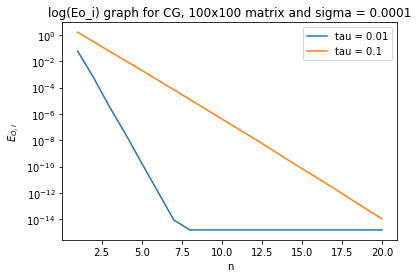

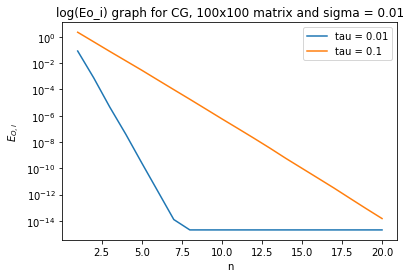

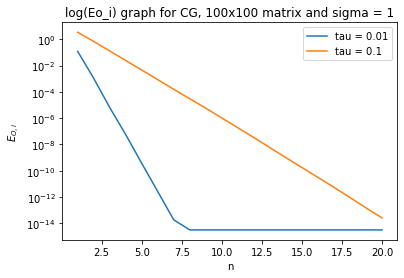

In [18]:
plt.figure()
plt.plot(np.arange(1,21),err_eo_a1[0,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a2[0,:],label = 'tau = 0.1')
plt.title('log(Eo_i) graph for CG, 100x100 matrix and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a1[1,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a2[1,:],label = 'tau = 0.1')
plt.title('log(Eo_i) graph for CG, 100x100 matrix and sigma = 0.01')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a1[2,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a2[2,:],label = 'tau = 0.1')
plt.title('log(Eo_i) graph for CG, 100x100 matrix and sigma = 1')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)


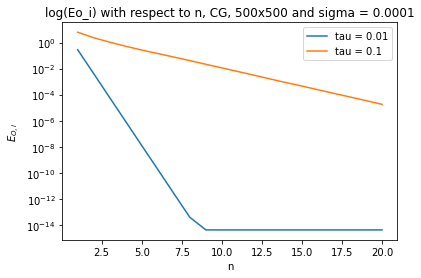

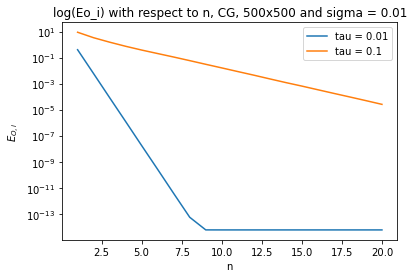

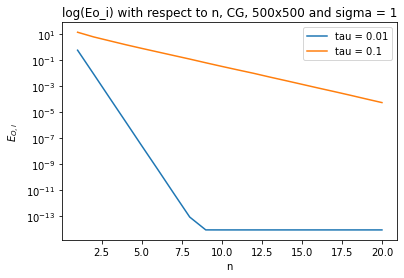

In [19]:
plt.figure()
plt.plot(np.arange(1,21),err_eo_a3[0,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a4[0,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a3[1,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a4[1,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 0.01')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a3[2,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a4[2,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 500x500 and sigma = 1')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

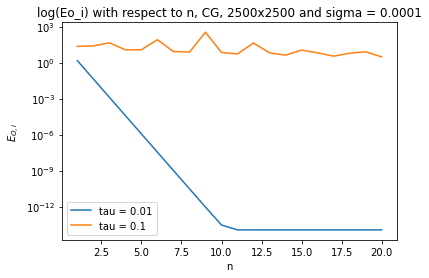

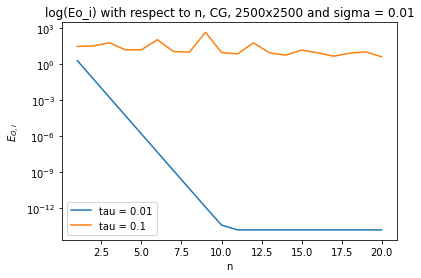

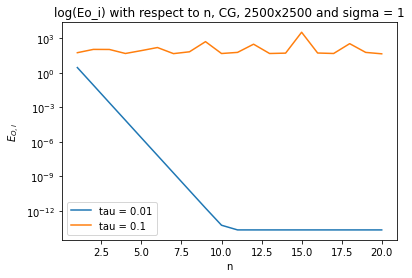

In [20]:
plt.figure()
plt.plot(np.arange(1,21),err_eo_a5[0,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a6[0,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 0.0001')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a5[1,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a6[1,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 0.01')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

plt.figure()
plt.plot(np.arange(1,21),err_eo_a5[2,:], label = 'tau = 0.01')
plt.plot(np.arange(1,21),err_eo_a6[2,:],label = 'tau = 0.1')
plt.title('log(Eo_i) with respect to n, CG, 2500x2500 and sigma = 1')
plt.yscale('log')
plt.ylabel('$E_{O,i}$')
plt.xlabel('n')
plt.legend() 
plt.show(block=False)

## Generalized Minimum Residual (GMRES)

In [21]:
def GMRES_by_Lancsoz(A,b_original,max_iter,tol):
    
    b = b_original.copy()#nx1 
    n = A.shape[0] 
    T_tilda = np.zeros((n+1, n)) 
    Q = np.zeros((n,n + 1)) 
    q1 = (b / np.linalg.norm(b)).reshape(-1)
    Q[:,0] = q1 
    
    e1 = np.zeros(n+1)
    e1[0] = np.linalg.norm(b)
    e1 = e1.reshape(-1,1)
    
    frob_err = []
    bk = 0
    for k in range(0,max_iter):# 0,1,.., m-1
        
        qk = Q[:,k]
        v = A @ qk
        ak = qk.T @ v
        
        if (k == 0):
            v = v - ak * qk
        else:
            v = v - bk * qk_prev - ak * qk
            
        bk = np.linalg.norm(v)
        qk_prev = qk
        qk =  v / bk
        Q[:,k + 1] = qk
        
        T_tilda[k,k] = ak
        T_tilda[k+1,k] = bk
        
        if k != max_iter - 1:
            T_tilda[k,k+1] = bk
        
        frob_err.append(np.linalg.norm(np.matmul(Q[:,:k+2].T,Q[:,:k+2])-np.eye(k+2,k+2)))
        
        Q_lst,R_lst = np.linalg.qr(T_tilda[:k+1,:k+1])
        R_lst_inv = np.linalg.pinv(R_lst)
        y_k = R_lst_inv @ (Q_lst.T @ e1[:k+1,0])
        x_hat = Q[:,:k+1] @ y_k
        
        
        if( frob_err[k] > tol):
            print('Stopped at Iteration: ', k + 1)
            print('Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to :', k, ':' ,frob_err)
            break
    
    x_hat = x_hat.reshape(-1,1)
    return x_hat


In [22]:
def err_es_lancsoz(A,b,x,max_iter,tolerance):
    
    err_n1 = []
    err_n2 = []
    err_n3 = []
    for i in range(30):
        x_hat = GMRES_by_Lancsoz(A,b[i],max_iter,tolerance)
        x_0 = x[:,np.mod(i,10)].reshape(-1,1)
        x_hat = x_hat.reshape(-1,1)
        if i <10:
            err1 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n1.append(err1)
        elif i >= 10 and i < 20:
            err2 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n2.append(err2)
        else:
            err3 = np.linalg.norm(-x_hat + x_0) ** 2
            err_n3.append(err3)
    
    err_n1 = (np.sum(err_n1) / 10) ** 0.5
    err_n2 = (np.sum(err_n2) / 10) ** 0.5
    err_n3 = (np.sum(err_n3) / 10) ** 0.5
    err_full = [err_n1,err_n2,err_n3]
    return err_full


In [23]:
gmres_err1_es = err_es_lancsoz(A1,b_30_1,x_1,A1.shape[0],1e-12) 
gmres_err2_es = err_es_lancsoz(A2,b_30_2,x_2,A2.shape[0],1e-12) 
gmres_err3_es = err_es_lancsoz(A3,b_30_3,x_3,A3.shape[0],1e-12) 
gmres_err4_es = err_es_lancsoz(A4,b_30_4,x_4,A4.shape[0],1e-12) 
gmres_err5_es = err_es_lancsoz(A5,b_30_5,x_5,A5.shape[0],1e-12) 
gmres_err6_es = err_es_lancsoz(A6,b_30_6,x_6,A6.shape[0],1e-12) 

Stopped at Iteration:  11
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 10 : [6.321231085033434e-14, 7.440495179072774e-14, 2.0823264091537525e-13, 2.549603542730741e-13, 3.5995941042571974e-13, 4.054008126725487e-13, 5.427284641608773e-13, 5.714651715400725e-13, 7.86391472930657e-13, 8.246391920226692e-13, 1.0586713915026593e-12]
Stopped at Iteration:  12
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 11 : [4.03596713990924e-14, 4.104411629498175e-14, 6.769653804040092e-14, 9.638387191524688e-14, 1.0722920836773898e-13, 1.4778222660105993e-13, 1.6509474088999763e-13, 2.107058726988824e-13, 3.0552535837565314e-13, 4.791053071870871e-13, 6.946430496812433e-13, 1.0137920329043615e-12]
Stopped at Iteration:  10
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 9 : [4.7683643962115585e-14, 4.918795536504609e-14, 8.635315155797826e-14, 1.1584755873347727e-13, 1.496572664301862e-13, 2.3693759832169863e-13, 3.2775406376563527e-13, 4.893371426263298e-13, 6.741422256301885

Stopped at Iteration:  27
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 26 : [5.325719128845297e-16, 1.2899126370273704e-15, 3.1053895400034523e-15, 4.253635348488777e-15, 6.218351377046952e-15, 6.617122142890821e-15, 8.373221553079513e-15, 9.275395384004171e-15, 9.898465246283677e-15, 1.0992780123799285e-14, 1.2318123883505808e-14, 1.4590928098808515e-14, 1.64858450280643e-14, 1.9402177224597816e-14, 2.0914643483103713e-14, 2.4339107347043562e-14, 2.655014171014584e-14, 3.127156328832612e-14, 3.706233897695673e-14, 4.736620648711289e-14, 6.11907000061667e-14, 8.426527302315469e-14, 1.2931462215471258e-13, 2.2276157342129175e-13, 3.7940994801143394e-13, 6.89048293361728e-13, 1.2500180101856993e-12]
Stopped at Iteration:  23
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 22 : [7.301585754228188e-16, 1.5964992405444988e-15, 2.5861509851270388e-15, 3.513397086732203e-15, 5.036251046848016e-15, 6.033478866210534e-15, 8.011592718777916e-15, 9.984301906315996e-15, 1.38218422

Stopped at Iteration:  26
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 25 : [7.741159318832995e-16, 8.955219721717083e-16, 1.5214385298654095e-15, 3.3264099536543074e-15, 4.166979003838071e-15, 4.938032351513004e-15, 6.5185710683928114e-15, 7.270215980202113e-15, 8.632234472996138e-15, 1.0222500413748245e-14, 1.0785473260847986e-14, 1.2340927661783368e-14, 1.3082850789386574e-14, 1.4271780279922663e-14, 1.598536293741105e-14, 1.820339953603876e-14, 2.2334345491921125e-14, 3.00101421306519e-14, 3.974840900746654e-14, 5.4291826889027365e-14, 7.647786307554163e-14, 1.0910133013936389e-13, 1.7208812696369045e-13, 3.1552832729081593e-13, 5.718454362956969e-13, 1.0303038556775575e-12]
Stopped at Iteration:  24
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 23 : [3.359757101522113e-15, 3.929002271026635e-15, 7.14312450952468e-15, 9.540493856065167e-15, 1.0772972229229296e-14, 1.2841202485847458e-14, 1.3539392305005151e-14, 1.582928490469648e-14, 1.6555076732154167e-14, 1.955

Stopped at Iteration:  13
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 12 : [3.2384679438462914e-14, 4.508063228767071e-14, 9.522081463926381e-14, 1.382946597552933e-13, 2.1879985967897328e-13, 2.68391718587196e-13, 3.9138643414248816e-13, 4.251639790156562e-13, 5.85266619691576e-13, 6.309028361282088e-13, 8.107681929255059e-13, 8.518823460303423e-13, 1.0500749515268173e-12]
Stopped at Iteration:  26
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 25 : [2.4587919879928944e-14, 2.4879998937534476e-14, 4.0478181089087975e-14, 4.284305266239472e-14, 6.275047730525391e-14, 7.227833143294767e-14, 1.0688344140465116e-13, 1.1822492891273021e-13, 1.533831758917698e-13, 1.751846320773488e-13, 2.3099414753626994e-13, 2.52669065835135e-13, 3.092789403126652e-13, 3.3764940143914067e-13, 4.0420433742568477e-13, 4.3185456314086947e-13, 4.941124017160107e-13, 5.217285113636403e-13, 6.089202075512184e-13, 6.393182810230272e-13, 7.264073692529614e-13, 7.582305794557452e-13, 8.624797382

Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 29 : [2.138760321063305e-14, 3.579187691399679e-14, 6.1183255076899e-14, 7.197253486794773e-14, 9.341726376384524e-14, 1.26858377909416e-13, 1.3067491633832983e-13, 1.4926372248155506e-13, 1.7226198047348331e-13, 1.7716207754540116e-13, 1.968479244785704e-13, 2.1467166063283645e-13, 2.298867100544342e-13, 2.586361637775913e-13, 2.8371280018160584e-13, 3.1691980512229056e-13, 3.4551295168829097e-13, 3.695023593729601e-13, 4.024194737277842e-13, 4.2506567927973283e-13, 4.522163930561821e-13, 4.783219375585506e-13, 5.161716140133055e-13, 5.596287697945267e-13, 6.097986285666561e-13, 6.726631786890487e-13, 7.505308751625856e-13, 8.430485450241818e-13, 9.46322728953957e-13, 1.1121817977393619e-12]
Stopped at Iteration:  27
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 26 : [1.9329407741738388e-14, 2.3413281473112424e-14, 4.376998603272169e-14, 4.500060894300119e-14, 6.785494022196934e-14, 7.890090859312885e-14, 8.78497367048224

Stopped at Iteration:  47
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 46 : [1.5255785923035086e-15, 2.1526513458563635e-15, 3.781409156809016e-15, 4.734294164849933e-15, 6.156094084726278e-15, 7.347913137499272e-15, 9.063574100916718e-15, 1.1380152761763868e-14, 1.3214100047580704e-14, 1.582534614490027e-14, 1.8216219594837798e-14, 2.087270129560842e-14, 2.4157967680805614e-14, 2.6540158020495082e-14, 3.0126538551100095e-14, 3.2819481524355596e-14, 3.6211596390981036e-14, 3.9152528875311107e-14, 4.172428595098423e-14, 4.457534857263893e-14, 4.767239376745265e-14, 5.139218266247772e-14, 5.462610697424037e-14, 5.827964229460809e-14, 6.167302171853125e-14, 6.533796158641655e-14, 6.912755569998808e-14, 7.277658677450504e-14, 7.798349300733407e-14, 8.204138863013131e-14, 8.76783568796154e-14, 9.304147433577241e-14, 1.0058537800720922e-13, 1.0773755437744487e-13, 1.1730566361289508e-13, 1.238889843536394e-13, 1.33699486958913e-13, 1.448757163697416e-13, 1.6115038150035652e-13, 1.8

Stopped at Iteration:  49
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 48 : [1.1430445635548515e-15, 2.4414900262954218e-15, 3.707448490559749e-15, 5.283304651323246e-15, 6.7939935291875876e-15, 8.756316493033453e-15, 1.0399180036889079e-14, 1.2445779793156661e-14, 1.4192815681774492e-14, 1.6986503537399606e-14, 1.8304445621408722e-14, 2.095674158599739e-14, 2.1971407172052677e-14, 2.4513541601388017e-14, 2.5365741060377328e-14, 2.805665578386952e-14, 2.891102413261675e-14, 3.1288271208632657e-14, 3.2322512662441316e-14, 3.4580475972842225e-14, 3.5776004510319686e-14, 3.826813870030372e-14, 3.969125620890169e-14, 4.1996225631374307e-14, 4.331121777807153e-14, 4.5665506435687894e-14, 4.7359079372994326e-14, 4.964049464382909e-14, 5.1373813308053485e-14, 5.393734208755028e-14, 5.575452677882864e-14, 5.861495808610791e-14, 6.08392564331179e-14, 6.380060666316676e-14, 6.679833739974908e-14, 7.074670939442213e-14, 7.570827216573426e-14, 8.249626720062877e-14, 9.192458107666658e-14

Stopped at Iteration:  51
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 50 : [7.425437182998249e-16, 2.646044462699452e-15, 5.567425885740816e-15, 8.513827802848902e-15, 1.236224137016156e-14, 1.519174746858126e-14, 1.98830193518903e-14, 2.2321660611131134e-14, 2.7495494906664615e-14, 2.908998243551643e-14, 3.464432086087847e-14, 3.618422830072654e-14, 4.2383826534400596e-14, 4.4183187129228784e-14, 5.058987015125692e-14, 5.2079374835202416e-14, 5.944151388938073e-14, 6.09305826118295e-14, 6.907387211990488e-14, 7.051374556630611e-14, 7.875634029466213e-14, 7.989247911789462e-14, 8.813278324120514e-14, 8.89996600595305e-14, 9.764072256788149e-14, 9.843592039693283e-14, 1.0817447542316897e-13, 1.0907300969564053e-13, 1.1842337869028073e-13, 1.192588643174457e-13, 1.2774729855232295e-13, 1.2840000809527793e-13, 1.3701056039372862e-13, 1.3769413292171683e-13, 1.4583097152488788e-13, 1.4710389633444318e-13, 1.5466116673244975e-13, 1.5601219053848083e-13, 1.6328099004500702e-13, 1.

Stopped at Iteration:  19
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 18 : [8.43848031871695e-15, 2.7602747744724704e-14, 5.400099344066215e-14, 8.684840134511124e-14, 1.350566197925123e-13, 1.5976664083513469e-13, 2.2515708415907918e-13, 2.529451552864395e-13, 3.386041296839013e-13, 3.7096756877657004e-13, 4.652359103252141e-13, 5.004400071378843e-13, 6.102326233321653e-13, 6.453868646303538e-13, 7.498469095824575e-13, 7.806852754249092e-13, 8.933770389186863e-13, 9.168425360388765e-13, 1.018211249312941e-12]
Stopped at Iteration:  31
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 30 : [5.969292534655037e-15, 1.0753784851550178e-14, 2.1339063211874646e-14, 3.8137641681958146e-14, 5.285893462913643e-14, 7.624648532458415e-14, 1.0150934040428995e-13, 1.3128944048582246e-13, 1.6379012256259439e-13, 1.919059187985978e-13, 2.3699613428836337e-13, 2.654259176313928e-13, 3.1039532164651594e-13, 3.378723754957633e-13, 3.871384561374714e-13, 4.037407710522362e-13, 4.54357293

Stopped at Iteration:  31
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 30 : [8.919254122035111e-15, 1.534221434170464e-14, 2.7705946705810447e-14, 3.0525489561925807e-14, 3.918361811049887e-14, 4.976042181675977e-14, 6.822120243478498e-14, 7.283969074435929e-14, 9.344674536625366e-14, 1.0591200100319708e-13, 1.2765610109771202e-13, 1.4014192178573997e-13, 1.731923376226517e-13, 1.9472567493618148e-13, 2.337465405769927e-13, 2.6670600503109555e-13, 3.216115436904173e-13, 3.5536552474087807e-13, 4.0560657882081376e-13, 4.3945385211603485e-13, 4.922438606218287e-13, 5.239272772549095e-13, 5.829192928506384e-13, 6.167213308218502e-13, 6.847712725048027e-13, 7.208302564839713e-13, 8.001274543026512e-13, 8.388628840699638e-13, 9.228544772334394e-13, 9.578707360182017e-13, 1.0383994911499225e-12]
Stopped at Iteration:  28
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 27 : [1.552885073315046e-14, 2.0971150819367238e-14, 6.109410778350821e-14, 7.428362115791034e-14, 1.0630243

Stopped at Iteration:  23
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 22 : [1.1503533858667014e-14, 2.1540897456397346e-14, 4.302473395909773e-14, 4.966107638345668e-14, 8.108236159491559e-14, 9.352879996221302e-14, 1.4155694389963622e-13, 1.741917738070722e-13, 2.392802769887366e-13, 2.71249854771626e-13, 3.4396386003690487e-13, 3.804968926114785e-13, 4.5301812209900257e-13, 4.79414801712442e-13, 5.54957123747608e-13, 5.770478366593521e-13, 6.582481479009285e-13, 6.78084522920799e-13, 7.685988236748486e-13, 7.952456494923079e-13, 8.984151938750135e-13, 9.28557388412689e-13, 1.041582700096466e-12]
Stopped at Iteration:  23
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 22 : [5.41944136967667e-15, 2.666875152401213e-14, 6.241009487325038e-14, 8.814698511145449e-14, 1.3927101215459456e-13, 1.7551499893985996e-13, 2.44643282570664e-13, 2.7172209957847583e-13, 3.517723775860045e-13, 3.7165939636357505e-13, 4.5382156083185355e-13, 4.670384896201311e-13, 5.513653587017548e

Stopped at Iteration:  70
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 69 : [3.3084869171349085e-15, 4.68599040092216e-15, 5.612736255687089e-15, 9.721740482508563e-15, 1.1479925074063507e-14, 1.597683124531971e-14, 1.7430941287184228e-14, 2.0905430722045758e-14, 2.1629977185445702e-14, 2.642665217022749e-14, 2.741376720613285e-14, 3.176017634944094e-14, 3.2556222882480444e-14, 3.665442994122642e-14, 3.718001221785011e-14, 4.23800215001123e-14, 4.316532301604498e-14, 4.774035969956233e-14, 4.830352448686659e-14, 5.3335030146983134e-14, 5.41098524637137e-14, 5.983969724964532e-14, 6.089944283387758e-14, 6.642160508232092e-14, 6.721817929762948e-14, 7.330064409919966e-14, 7.425268025445373e-14, 8.059719643512404e-14, 8.186963808227122e-14, 8.864063513272525e-14, 8.973171089453027e-14, 9.685095391192694e-14, 9.798519628199485e-14, 1.0473825502645163e-13, 1.059163429889001e-13, 1.1296107929967762e-13, 1.1403263313837864e-13, 1.2170785236515117e-13, 1.22883357910027e-13, 1.2969246

Stopped at Iteration:  76
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 75 : [2.85169533953495e-16, 4.542105292825377e-16, 8.71283015483084e-16, 1.294814599144893e-15, 1.7053492931352183e-15, 2.232686362812362e-15, 3.4592613614974302e-15, 4.229508794413514e-15, 5.408651553306011e-15, 6.300831650174214e-15, 7.0054033525744405e-15, 7.843037948912986e-15, 8.410694279080701e-15, 9.482497745878583e-15, 1.0082436752729834e-14, 1.1524464643628639e-14, 1.260103016062732e-14, 1.4187307412865226e-14, 1.566265992032374e-14, 1.7583657332047042e-14, 1.8994245418835057e-14, 2.1258097347748928e-14, 2.2653629205066472e-14, 2.4931280946119292e-14, 2.621175617046975e-14, 2.9123493691053773e-14, 3.060220551134459e-14, 3.3661997062943646e-14, 3.547006191159209e-14, 3.8708901347640975e-14, 4.068107682000753e-14, 4.4585097481224686e-14, 4.6518341697403296e-14, 5.043783001912156e-14, 5.2651508310814966e-14, 5.6813591097341274e-14, 5.885370059555024e-14, 6.313875367742184e-14, 6.529246308542091e-14, 

Stopped at Iteration:  71
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 70 : [1.862435612267292e-15, 2.360975810783174e-15, 2.7773062298367922e-15, 4.01986904542733e-15, 4.752250524302584e-15, 6.21683347830209e-15, 6.972341030933444e-15, 8.128837168419734e-15, 8.51785489324744e-15, 1.0406345206581156e-14, 1.1318138654206729e-14, 1.3246396043555392e-14, 1.4049219125769335e-14, 1.6295404868631335e-14, 1.7133382460708573e-14, 2.0096556106857996e-14, 2.1160877174309853e-14, 2.3930830542762386e-14, 2.4674650534599704e-14, 2.745795598044182e-14, 2.8233505078596774e-14, 3.122070862253782e-14, 3.193272327037475e-14, 3.47131565816842e-14, 3.528857073342617e-14, 3.824665168763515e-14, 3.880350503658892e-14, 4.183717832040327e-14, 4.2460847662403323e-14, 4.5606725617333966e-14, 4.6159488997544963e-14, 4.94166322280671e-14, 4.999983183990636e-14, 5.310197128908975e-14, 5.3755517503421737e-14, 5.701832587677667e-14, 5.765378250177088e-14, 6.125313845306113e-14, 6.20238655821069e-14, 6.5439

Stopped at Iteration:  78
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 77 : [3.0772485504961567e-16, 9.21045542580358e-16, 1.7503219863963819e-15, 3.671471741996157e-15, 4.883684429975838e-15, 6.0462715322816485e-15, 6.626347405121629e-15, 7.328134683832036e-15, 7.691518069410932e-15, 8.471074069677862e-15, 9.33275417075e-15, 9.972573897398368e-15, 1.0875115435605143e-14, 1.1688141369639545e-14, 1.309064035717706e-14, 1.3791156521653342e-14, 1.5293673597371722e-14, 1.602802493982471e-14, 1.7799357583449717e-14, 1.880028538874979e-14, 2.0675791460358834e-14, 2.1741569139102632e-14, 2.3339638646421956e-14, 2.433003120274521e-14, 2.5808414134774627e-14, 2.7170190899801084e-14, 2.8444309391402726e-14, 2.98649776372142e-14, 3.092301635099671e-14, 3.240645027279463e-14, 3.3455979676372396e-14, 3.523737239026767e-14, 3.627923354503442e-14, 3.808161910510097e-14, 3.9300324026683553e-14, 4.117781075754272e-14, 4.256872811448438e-14, 4.464085913171224e-14, 4.6261761613105404e-14, 4.834

Stopped at Iteration:  90
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 89 : [1.9902148548550196e-16, 4.229103429681949e-16, 6.459519134083886e-16, 7.748745975363246e-16, 1.0613754936517337e-15, 1.4713123463759399e-15, 1.7625775961395942e-15, 2.1511077059168193e-15, 2.548970425436115e-15, 2.8694982387614573e-15, 3.246436252642856e-15, 3.446392547725131e-15, 3.776932235821003e-15, 4.2025189763439244e-15, 4.566835170122847e-15, 5.073195643854735e-15, 5.536319889727119e-15, 5.998644933708066e-15, 6.653207731737339e-15, 7.370466621833157e-15, 7.948303662491817e-15, 8.780231461535432e-15, 9.399425521617875e-15, 1.0217441876151742e-14, 1.1043085606399195e-14, 1.1978356784216232e-14, 1.3049543740943975e-14, 1.4205527412605178e-14, 1.5270448697401308e-14, 1.6576097250365853e-14, 1.791535218014875e-14, 1.9644478509693085e-14, 2.1187568952403107e-14, 2.3175933610013922e-14, 2.5398889501441992e-14, 2.7896043224901435e-14, 3.0408956208092424e-14, 3.347181976559076e-14, 3.6469209559355423e

Stopped at Iteration:  83
Frobenius_norm(Q_k.T Q_k - I_k) for iterations up to : 82 : [8.987209153278573e-16, 1.1156515374249154e-15, 1.6458094717466013e-15, 1.962956427524971e-15, 2.2987248301500898e-15, 2.610534289228946e-15, 3.31500989389826e-15, 3.6143145078085635e-15, 3.909351566691125e-15, 4.429831649872307e-15, 4.839333101972935e-15, 5.323358020858082e-15, 5.829002181614185e-15, 6.513218417390937e-15, 6.953950310016871e-15, 7.730540010087468e-15, 8.30609214702775e-15, 9.30995860769069e-15, 1.0096630540746043e-14, 1.1502065246892325e-14, 1.2561334106074688e-14, 1.3947406925525442e-14, 1.5157724976822643e-14, 1.692892563502759e-14, 1.85913822661251e-14, 2.0816697532738234e-14, 2.2914702169359187e-14, 2.5125324915016212e-14, 2.7436123390694608e-14, 2.988419989037751e-14, 3.2485765763031896e-14, 3.511661346349363e-14, 3.8114421091427705e-14, 4.107157624299808e-14, 4.4263078293609675e-14, 4.753883617688257e-14, 5.090230840036512e-14, 5.4435739207138544e-14, 5.78133509810545e-14, 6.14

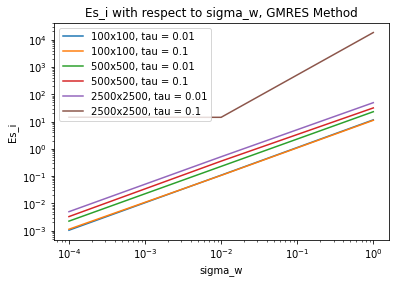

In [24]:
plt.figure()
w = [0.0001,0.01,1]
plt.plot(w,gmres_err1_es, label = '100x100, tau = 0.01')
plt.plot(w,gmres_err2_es, label = '100x100, tau = 0.1')
plt.plot(w,gmres_err3_es,label = '500x500, tau = 0.01')
plt.plot(w,gmres_err4_es, label = '500x500, tau = 0.1')
plt.plot(w,gmres_err5_es, label = '2500x2500, tau = 0.01')
plt.plot(w,gmres_err6_es, label = '2500x2500, tau = 0.1')

plt.title("Es_i with respect to sigma_w, GMRES Method")
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Es_i')
plt.xlabel('sigma_w')
plt.legend()
plt.show(block=False)